In [1]:
import sys
import torch.nn as nn
import torch.nn.functional as F
sys.path.append("../scripts")
from gen_torch_datasets import (
    gen_dataloaders, to_cuda, 
    plot_metrics, plot_confusion_matrix
)

In [2]:
train_loader, val_loader, input_shape, num_classes = gen_dataloaders(
    "/home/henrik/Documents/EDTH/CPH2025/drone_acoustics_train_val_data",
    4, 
    80
    # 96
)

Train samples: 540
Train labels 2160
Val samples: 180
Val labels 720


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class SpectrogramResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.3, reduction=16):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.layer1 = SpectrogramResNetBlock(32, 64, downsample=True, dropout=0.0)
        self.layer2 = SpectrogramResNetBlock(64, 128, downsample=True, dropout=0.0)
        self.layer3 = SpectrogramResNetBlock(128, 256, downsample=True, dropout=0.1)
        # self.layer4 = SpectrogramResNetBlock(256, 256, downsample=False, dropout=0.4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 

model = SpectrogramResNet(num_classes=num_classes)
model, device = to_cuda(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# Training loop
savepath = "/home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models"
for epoch in tqdm(range(50)):
    model.train()
    correct = 0
    total = 0
    acc = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        acc = correct / total
        optimizer.step()
    metrics["train_loss"].append(loss.item())
    metrics["train_acc"].append(acc)

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = correct / total
    
    if len(metrics["val_acc"]) > 1:
        if acc > np.amax(metrics["val_acc"]): 
            torch.save(model.state_dict(), f"{savepath}/best_val{acc:.4f}.pth")
    
    metrics["val_acc"].append(acc)


Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 2080 SUPER


100%|██████████| 60/60 [07:44<00:00,  7.74s/it]


Max Acc: 0.6472222222222223


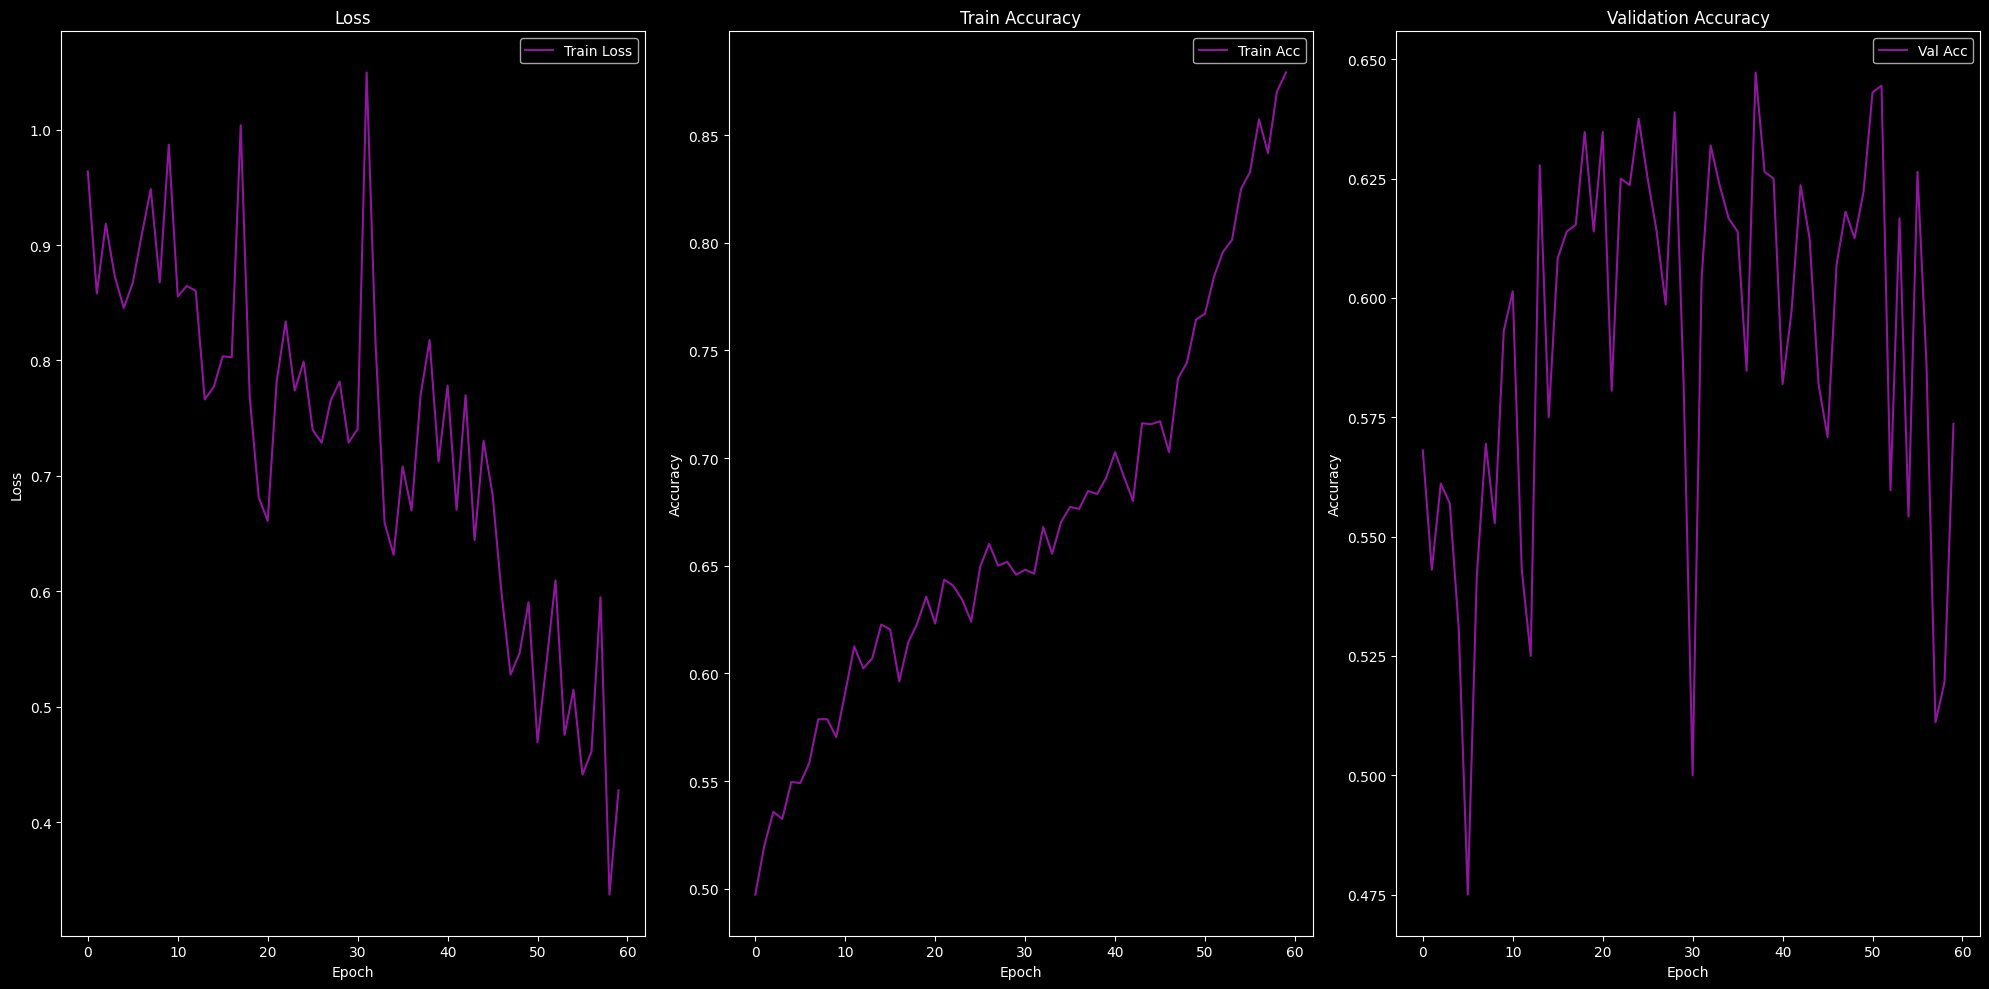

0.8791666666666667
0.6472222222222223


In [5]:
plot_metrics(metrics)
print(np.amax(metrics["train_acc"]))
print(np.amax(metrics["val_acc"]))

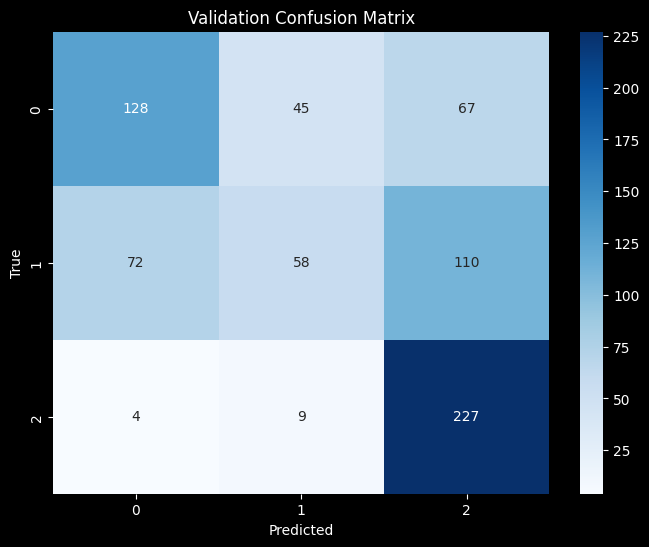

In [6]:
plot_confusion_matrix(model, device, num_classes, val_loader)

In [ ]:
# input_shape # torch.Size([512, 108])

torch.Size([512, 108])